In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#location of the data |
data_location =  "/content/drive/MyDrive/Datasets"
!ls $data_location

captions.txt  flickr8k.zip  Images


In [3]:
#reading the caption data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(5)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


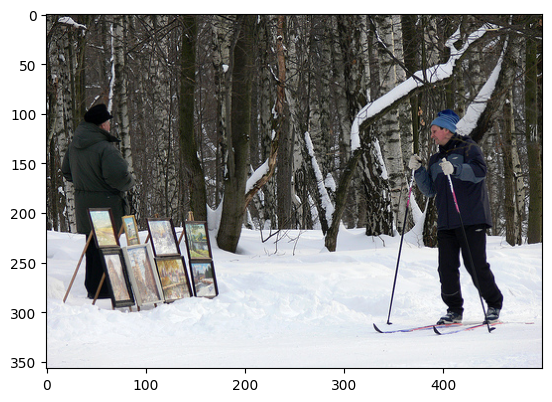

Caption: A man skis past another man displaying paintings in the snow .
Caption: A person wearing skis looking at framed pictures set up in the snow .
Caption: A skier looks at framed pictures in the snow next to trees .
Caption: Man on skis looking at artwork for sale in the snow
Caption: A collage of one person climbing a cliff .


In [4]:
#viewing the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#a image has 5 caption, so indx as: 1,6,11,16...
data_idx = 56

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [5]:
#vocabulary
import spacy
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place, to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', ',', 'to', 'find', 'a', 'city']

In [6]:
from collections import Counter
class Vocabulary:
    def __init__(self, freq_threshold):
        #setting the pre-reserved tokens 
        #int to string tokens
        self.intTostr = {0:"<PAD>", 
                     1:"<SOS>", 
                     2:"<EOS>", 
                     3:"<UNK>"}
        
        #string to int tokens
        self.strToint = {v:k for k,v in self.intTostr.items()}
        #minimum frequency reqd to be part of vocab
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.intTostr)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4 #index for intTostr
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.strToint[word] = idx
                    self.intTostr[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word 
            form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.strToint[token] 
                if token in self.strToint 
                else self.strToint["<UNK>"] 
                for token in tokenized_text ]  

In [7]:
#testing the vocab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to , find a city good"])
print(v.strToint)
print(v.numericalize("This is a good place to find a good city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, ',': 10, 'find': 11, 'city': 12}
[4, 5, 6, 7, 8, 9, 11, 6, 7, 12, 3, 3, 3]


In [8]:
import os
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

In [9]:
#setting up the device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
#seting up the pytorch dataset
class Flickr8kDataset(Dataset):
    """
    Flickr8kDataset
    """
    def __init__(self, image_file, captions_file, transform=None, 
                  freq_threshold=5):
        self.image_file = image_file
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.image_file,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.strToint["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.strToint["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [11]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  Flickr8kDataset(
    image_file = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)

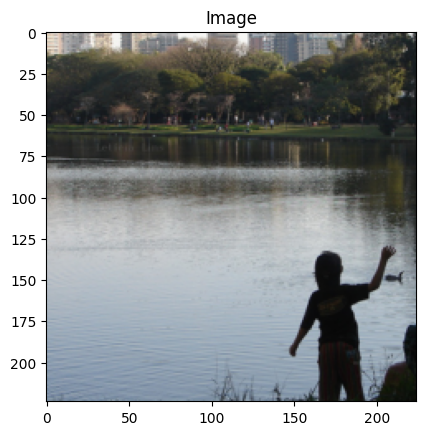

Token: tensor([  1,   4,  28,  16,   4,  80,  34,  19, 766, 163,   8,   4, 250, 215,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


In [13]:
#example Flicker8kDataset
img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.intTostr[token] for token in caps.tolist()])

In [14]:
class generate_batch_captions:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
      #Each batch (image_tensor, caption_tensor)

      #image_tensor = [bach_size, num_channels, height, width]
      #caption_tensor = [batch_size, num_words_in_captions]

      #Add an extra dimension of size 1 at index 0
      #[num_channels, height, widht] -> [1, num_channel. height, width]
      imgs = [item[0].unsqueeze(0) for item in batch]
      imgs = torch.cat(imgs,dim=0)
      
      targets = [item[1] for item in batch]
      targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
      return imgs,targets

In [15]:
#writing the dataloader
#setting the constants
batch_size = 128
num_workers = 1

#token to represent the padding
pad_idx = dataset.vocab.strToint["<PAD>"]

data_loader = DataLoader(
    dataset = dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    shuffle = True,
    collate_fn = generate_batch_captions(pad_idx=pad_idx,batch_first=True)
)

## **Encoder**

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2] 
        self.resnet = nn.Sequential(*modules)
        # self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        

    def forward(self, images):
      #Generate feature of the shape [batch_size, 2048, 7, 7]
      #The o/p of the last later of resenet produces 7X7 feature maps
      #image_size / 32 = 224 /32 = 7
      features = self.resnet(images)                #(batch_size,2048,7,7)
      batch, feature_maps, height, width = features.size()
      #(batch_size, 7, 7, 2048)
      features = features.permute(0, 2, 3, 1)    
      #(batch_size, 49, 2048)
      features = features.view(batch, -1, feature_maps)
      return features


In [19]:
class Attention(nn.Module):
  def __init__(self, enc_hidden_size, dec_hidden_size, attn_size):
    super(Attention, self).__init__()

    self.attn_size = attn_size

    self.enc_U = nn.Linear(enc_hidden_size, attn_size)
    self.dec_W = nn.Linear(dec_hidden_size, attn_size)

    self.full_A = nn.Linear(attn_size, 1)

  def forward(self, features, decoder_hidden_state):
    # [batch_size, dec_hidden_size] -> [batch_size, 1, dec_hidden_size]
    decoder_hidden_state = decoder_hidden_state.unsqueeze(1)

    # [batch_size, 49, 2048] -> [batch_size, 49, attn_size]
    enc_att = self.enc_U(features)

    # [batch_size, 1, dec_hidden_size] -> [batch_size, 1, attn_size]
    dec_att = self.dec_W(decoder_hidden_state)

    # [batch_size, 49, attn_size]
    combined_states = torch.tanh(enc_att + dec_att)
    
    #attn_scores shape [batch_size, 49, 1]
    attn_scores = self.full_A(combined_states)
    
    # [batch_size, 49, 1] -> [batch_size, 49]
    attn_scores = attn_scores.squeeze(2)

    # attn_weight shape [batch_size, 49]
    attn_weight = F.softmax(attn_scores, dim = 1)

    # context shape [batch_size, 2048]-> 
                    # [batch_size, 49]*[batch_size, 49, 2048]
    # context has same dimensions as the encoding output ie the encoding_hidden_size
    context = torch.sum(attn_weight.unsqueeze(2)*features, dim = 1)

    return attn_weight, context 


In [20]:
class DecoderRNN(nn.Module):
  def __init__(self, emb_size, vocab_size, attn_size,
               enc_hidden_size, dec_hidden_size, drop_prob = 0.3):
    
      super(DecoderRNN, self).__init__()

      self.vocab_size = vocab_size
      self.attn_size = attn_size
      self.dec_hidden_size = dec_hidden_size

      self.embedding = nn.Embedding(vocab_size, emb_size)
      self.attn = Attention(enc_hidden_size, dec_hidden_size, attn_size)

      self.init_h = nn.Linear(enc_hidden_size, dec_hidden_size)
      self.init_c = nn.Linear(enc_hidden_size, dec_hidden_size)

      self.lstm_cell = nn.LSTMCell(emb_size+enc_hidden_size, dec_hidden_size, bias = True)

      self.fcn = nn.Linear(dec_hidden_size, vocab_size)
      self.drop = nn.Dropout(drop_prob)                       

  def forward(self, features, captions):  
      #vectorize the caption
      embeds = self.embedding(captions)
      
      # Initialize LSTM state
      h, c = self.init_hidden_state(features)  # (batch_size, dec_hidden_size)
      
      #get the seq length to iterate
      seq_length = len(captions[0])-1 #Exclude the last one
      batch_size = captions.size(0)
      num_features = features.size(1) #(batch_size, 49, 2048)
      
      # predicted captions in form of one-hot vectors
      preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
      attn_weights = torch.zeros(batch_size, seq_length,num_features).to(device)
      
      # feed in the input for each time instance along with context vectors
      for s in range(seq_length):
          # first, pass the features and decoder hidden state
          attn_weight,context = self.attn(features, h)
          
          # lstm input are embeddings repr words and context vectors
          lstm_input = torch.cat((embeds[:, s], context), dim=1)
          
          # hidden state for next time instance
          h, c = self.lstm_cell(lstm_input, (h, c))
          
          # pass through dropout layer
          output = self.fcn(self.drop(h))
          
          # get the prediction and weights
          preds[:,s] = output
          attn_weights[:,s] = attn_weight  
      
      return preds, attn_weights

      
  def generate_caption(self, features, max_len=20, vocab=None):
      # Inference part
      # Given the image features generate the captions
      
      batch_size = features.size(0)
      h, c = self.init_hidden_state(features)  # (batch_size, dec_hidden_size)
      
      # store the weights
      attn_weights = []
      
      #starting input
      word = torch.tensor(vocab.strToint['<SOS>']).view(1,-1).to(device)
      embeds = self.embedding(word)

      # captions generated 
      captions = []
      
      for i in range(max_len):
          # take encoder output and compute the current attention
          attn_weight,context = self.attn(features, h)
          
          #store the apla score
          attn_weights.append(attn_weight.cpu().detach().numpy())
          
          # conatenation of current state embeddings and context vectors
          lstm_input = torch.cat((embeds[:, 0], context), dim=1)
          h, c = self.lstm_cell(lstm_input, (h, c))
          output = self.fcn(self.drop(h))
          output = output.view(batch_size,-1)
          
          #select the word with most val
          predicted_word_idx = output.argmax(dim=1)
          
          #save the generated word
          captions.append(predicted_word_idx.item())
          
          #end if <EOS detected>
          if vocab.intTostr[predicted_word_idx.item()] == "<EOS>":
              break
          
          #send generated word as the next caption
          embeds = self.embedding(predicted_word_idx.unsqueeze(0))
      
      #covert the vocab idx to words and return sentence
      return [vocab.intTostr[idx] for idx in captions], attn_weights
  
  # features from encoder CNN 
  def init_hidden_state(self, features):
    mean_features = torch.mean(features, dim = 1)
    h = self.init_h(mean_features)
    c = self.init_c(mean_features)
    return h, c
      

In [21]:
# Seq2Seq model to generate image captions

class Image2Captions(nn.Module):
    def __init__(self,emb_size, vocab_size, attn_size,enc_hidden_size,dec_hidden_size,drop_prob=0.3):
        super().__init__()
        # encoder doesn't need any params to specify
        self.encoder = EncoderCNN()
        # decoder params need to be specified
        self.decoder = DecoderRNN(
            emb_size=emb_size,
            vocab_size = len(dataset.vocab),
            attn_size=attn_size,
            enc_hidden_size=enc_hidden_size,
            dec_hidden_size=dec_hidden_size
        )
    
    def forward(self, images, captions):
        # pass the images through encoder to ger feature representations
        features = self.encoder(images)
        # features and captions are passed to decoder
        outputs = self.decoder(features, captions)
        return outputs

In [22]:
# Hyperparams to tweak

emb_size=300
vocab_size = len(dataset.vocab)
attn_size =256
enc_hidden_size = 2048
dec_hidden_size  = 512
learning_rate = 0.01

In [23]:
# Seq2Seq model initialization

model = Image2Captions(
    emb_size=300,
    vocab_size = len(dataset.vocab),
    attn_size = 256,
    enc_hidden_size =2048,
    dec_hidden_size = 512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.strToint["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 296MB/s]


In [24]:
from google.colab import files
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':emb_size,
        'vocab_size':len(dataset.vocab),
        'attention_size':attn_size,
        'enc_hidden_size':enc_hidden_size,
        'dec_hidden_size':dec_hidden_size,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state1.pth')
    # download checkpoint file
    files.download('attention_model_state1.pth')

In [ ]:
# model = model(*args, **kwargs)
model.load_state_dict(torch.load('attention_model_state.pth'))

In [ ]:
num_epochs = 25
print_every = 10

for epoch in range(1,num_epochs+1):
  for idx, (image, captions) in enumerate(iter(data_loader)):
    image,captions = image.to(device),captions.to(device)

    # Zero the gradients.
    optimizer.zero_grad()

    # Feed forward
    outputs,attentions = model(image, captions)

    # Calculate the batch loss.
    targets = captions[:,1:]
    loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

    # Backward pass.
    loss.backward()

    # Update the parameters in the optimizer.
    optimizer.step()

    if (idx+1)%print_every == 0:
      print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
  
      #generate the caption and display it
      model.eval()
      with torch.no_grad():
        img, _ = next(iter(data_loader))
        features = model.encoder(img[0:1].to(device))
        caps,attn_weights = model.decoder.generate_caption(features, vocab=dataset.vocab)

        caption = ' '.join(caps)
        show_image(img[0],title=caption)

      model.train()

  #save the latest model after every epoch
  save_model(model,epoch)